# Causal analysis pipeline — Endangered species in Asia

**Notebook purpose:** Complete pipeline (data ingestion → preprocessing → causal analysis → robustness) for endangered species in Asia with natural disasters as treatment.

**Geographic scope:** Asia bounding box [60°E, -10°S] to [150°E, 55°N]

**Temporal scope:** 2000–2024 (annual aggregation)

**Spatial resolution:** 0.1° grid (~11 km at equator)

**Disaster types:** Wildfires, floods, cyclones/typhoons, earthquakes

**Species:** IUCN threatened (CR, EN, VU) Aves, Mammalia, Reptilia, Amphibia with ≥50 GBIF occurrences

**Estimators:** DiD (TWFE), Sun-Abraham (staggered), Synthetic Control, Bayesian hierarchical

**Outputs:** Event-study plots, coefficient tables, maps, species summaries, robustness checks, processed panels

**Structure:**
1. Setup & dependencies
2. Configuration
3. Data ingestion: GBIF, EM-DAT, IUCN, hazard footprints
4. Preprocessing & grid alignment
5. Treatment construction
6. Outcome construction
7. Causal estimation (DiD, SCM, Bayesian)
8. Robustness & falsification
9. Visualization & reporting

In [ ]:
# 2. Configuration — project parameters
from pathlib import Path
import datetime
import json
from dotenv import load_dotenv
import os

load_dotenv()

CONFIG = {
    'study_name': 'endangered_asia_disaster_analysis',
    'data_dir': Path('data'),  # relative to notebook location
    'results_dir': Path('results'),
    'notebook_generated_on': datetime.datetime.utcnow().isoformat() + 'Z',
    
    # Spatial parameters
    'grid_resolution_deg': 0.1,
    'region_bbox': [60.0, -10.0, 150.0, 55.0],  # [min_lon, min_lat, max_lon, max_lat]
    
    # Temporal parameters
    'time_unit': 'year',
    'time_range': (2000, 2024),
    
    # Species selection
    'taxa': ['Aves', 'Mammalia', 'Reptilia', 'Amphibia'],
    'target_status': ['CR', 'EN', 'VU'],
    'min_occurrences': 50,  # minimum GBIF records per species
    
    # Disaster types
    'disaster_types': ['wildfire', 'flood', 'cyclone', 'earthquake'],
    
    # API credentials (fill these in)
    'gbif_user': None,  # GBIF username
    'gbif_password': None,  # GBIF password
    'gbif_email': None,
    'iucn_token': None,  # IUCN API token (if using API)
    
    # Analysis parameters
    'event_window': (-3, 5),  # years before/after for event study
    'clustering_var': 'grid_id',  # for standard errors
    'did_estimator': 'twfe',  # 'twfe', 'sun_abraham', or 'both'
    
    # Output formats
    'save_intermediate': True,
    'figure_format': 'png',
    'figure_dpi': 300,
}

CONFIG['gbif_user'] = os.getenv('GBIF_USER')
CONFIG['gbif_password'] = os.getenv('GBIF_PASSWORD')
CONFIG['gbif_email'] = os.getenv('GBIF_EMAIL')
CONFIG['iucn_token'] = os.getenv('IUCN_TOKEN')

# Create directories
for dir_path in [CONFIG['data_dir'], CONFIG['results_dir']]:
    dir_path.mkdir(parents=True, exist_ok=True)
    (dir_path / 'raw').mkdir(exist_ok=True)
    (dir_path / 'processed').mkdir(exist_ok=True)

# Save config
with open(CONFIG['results_dir'] / 'config.json', 'w') as f:
    json.dump({k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()}, f, indent=2)

print(f"Configuration set for {CONFIG['study_name']}")
print(f"Study region: {CONFIG['region_bbox']}")
print(f"Time range: {CONFIG['time_range']}")
print(f"Grid resolution: {CONFIG['grid_resolution_deg']}°")
CONFIG

Configuration set for endangered_asia_disaster_analysis
Study region: [60.0, -10.0, 150.0, 55.0]
Time range: (2000, 2024)
Grid resolution: 0.1°


C:\Users\appoo\AppData\Local\Temp\ipykernel_15880\2685328261.py:10: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'notebook_generated_on': datetime.datetime.utcnow().isoformat() + 'Z',


{'study_name': 'endangered_asia_disaster_analysis',
 'data_dir': WindowsPath('data'),
 'results_dir': WindowsPath('results'),
 'notebook_generated_on': '2025-11-06T06:48:54.186057Z',
 'grid_resolution_deg': 0.1,
 'region_bbox': [60.0, -10.0, 150.0, 55.0],
 'time_unit': 'year',
 'time_range': (2000, 2024),
 'taxa': ['Aves', 'Mammalia', 'Reptilia', 'Amphibia'],
 'target_status': ['CR', 'EN', 'VU'],
 'min_occurrences': 50,
 'disaster_types': ['wildfire', 'flood', 'cyclone', 'earthquake'],
 'gbif_user': 'advaithmagic',
 'gbif_password': 'gbifADA*1843',
 'gbif_email': 'advaithsanilkumar@gmail.com',
 'iucn_token': None,
 'event_window': (-3, 5),
 'clustering_var': 'grid_id',
 'did_estimator': 'twfe',
 'save_intermediate': True,
 'figure_format': 'png',
 'figure_dpi': 300}

## 3. Data Sources Overview

**EM-DAT (CRED):** Global disaster records - requires registration at https://www.emdat.be/
- Download disasters for Asia, 2000-2024
- Filter by disaster types: wildfire, flood, storm, earthquake
- Save as `data/raw/emdat_asia_2000_2024.csv`

**GBIF:** Species occurrence data via API
- Implemented below with bulk download workflow
- Requires GBIF account (free): https://www.gbif.org/

**IUCN Red List:** Species range maps
- Download from https://www.iucnredlist.org/resources/spatial-data-download
- Requires acceptance of terms
- Save shapefiles to `data/raw/iucn/`

**Hazard-specific footprints:**
- MODIS/VIIRS burned area: https://modis-fire.umd.edu/
- Copernicus EMS flood footprints: https://emergency.copernicus.eu/
- USGS earthquake data: https://earthquake.usgs.gov/
- NASA GPM IMERG precipitation: https://gpm.nasa.gov/

**MODIS MCD12 land cover:** Annual global land cover at 500m
- Download from https://lpdaac.usgs.gov/products/mcd12q1v006/

In [4]:
# 4a. GBIF species list acquisition - get threatened species in Asia
import requests
import pandas as pd
from pygbif import species as gbif_species
from pygbif import occurrences as gbif_occ
import time

def get_iucn_threatened_species_asia(taxa_list, status_list, bbox, iucn_token=None):
    """
    Query IUCN Red List API for threatened species in Asia.
    If no API token, returns a curated list of example species.
    
    For production: Get API token from https://apiv3.iucnredlist.org/api/v3/token
    """
    species_list = []
    
    if iucn_token:
        # Use IUCN API
        base_url = "https://apiv3.iucnredlist.org/api/v3"
        headers = {'token': iucn_token}
        
        for taxon in taxa_list:
            for status in status_list:
                try:
                    # Get species by category and taxon
                    url = f"{base_url}/species/category/{status}"
                    response = requests.get(url, headers=headers, timeout=30)
                    if response.status_code == 200:
                        data = response.json()
                        for sp in data.get('result', []):
                            if sp.get('class_name', '').lower() == taxon.lower():
                                species_list.append({
                                    'taxon': taxon,
                                    'scientificName': sp.get('scientific_name'),
                                    'status': status,
                                    'taxonid': sp.get('taxonid')
                                })
                    time.sleep(0.5)  # Rate limiting
                except Exception as e:
                    print(f"Error fetching {taxon} - {status}: {e}")
    else:
        print("No IUCN token provided. Using curated example species list.")
        print("For production: Set CONFIG['iucn_token'] with your API token")
        
        # Curated list of threatened species in Asia (examples from each taxonomic group)
        species_list = [
            # Aves (Birds)
            {'taxon': 'Aves', 'scientificName': 'Lophura edwardsi', 'status': 'CR'},
            {'taxon': 'Aves', 'scientificName': 'Arborophila davidi', 'status': 'EN'},
            {'taxon': 'Aves', 'scientificName': 'Turdoides striata', 'status': 'VU'},
            {'taxon': 'Aves', 'scientificName': 'Carpococcyx renauldi', 'status': 'EN'},
            
            # Mammalia (Mammals)
            {'taxon': 'Mammalia', 'scientificName': 'Panthera tigris', 'status': 'EN'},
            {'taxon': 'Mammalia', 'scientificName': 'Elephas maximus', 'status': 'EN'},
            {'taxon': 'Mammalia', 'scientificName': 'Rhinoceros sondaicus', 'status': 'CR'},
            {'taxon': 'Mammalia', 'scientificName': 'Pongo abelii', 'status': 'CR'},
            
            # Reptilia (Reptiles)
            {'taxon': 'Reptilia', 'scientificName': 'Crocodylus siamensis', 'status': 'CR'},
            {'taxon': 'Reptilia', 'scientificName': 'Chelonia mydas', 'status': 'EN'},
            {'taxon': 'Reptilia', 'scientificName': 'Cuora trifasciata', 'status': 'CR'},
            
            # Amphibia (Amphibians)
            {'taxon': 'Amphibia', 'scientificName': 'Ansonia latidisca', 'status': 'EN'},
            {'taxon': 'Amphibia', 'scientificName': 'Rhacophorus catamitus', 'status': 'VU'},
        ]
    
    return pd.DataFrame(species_list)

# Get species list
species_df = get_iucn_threatened_species_asia(
    CONFIG['taxa'], 
    CONFIG['target_status'],
    CONFIG['region_bbox'],
    iucn_token=CONFIG['iucn_token']
)

print(f"\nSpecies to analyze: {len(species_df)}")
print(f"Taxonomic groups: {species_df['taxon'].value_counts().to_dict()}")
print(f"Conservation status: {species_df['status'].value_counts().to_dict()}")

# Save species list
species_df.to_csv(CONFIG['data_dir'] / 'processed' / 'target_species.csv', index=False)
print(f"\nSaved species list to {CONFIG['data_dir'] / 'processed' / 'target_species.csv'}")

species_df.head(10)

No IUCN token provided. Using curated example species list.
For production: Set CONFIG['iucn_token'] with your API token

Species to analyze: 13
Taxonomic groups: {'Aves': 4, 'Mammalia': 4, 'Reptilia': 3, 'Amphibia': 2}
Conservation status: {'EN': 6, 'CR': 5, 'VU': 2}

Saved species list to data\processed\target_species.csv


,taxon,scientificName,status
0,Aves,Lophura edwardsi,CR
1,Aves,Arborophila davidi,EN
2,Aves,Turdoides striata,VU
3,Aves,Carpococcyx renauldi,EN
4,Mammalia,Panthera tigris,EN
5,Mammalia,Elephas maximus,EN
6,Mammalia,Rhinoceros sondaicus,CR
7,Mammalia,Pongo abelii,CR
8,Reptilia,Crocodylus siamensis,CR
9,Reptilia,Chelonia mydas,EN


In [15]:
# 4b. GBIF bulk occurrence download workflow
from pygbif import occurrences as occ
import time
import zipfile
import os

def request_gbif_download(species_list, year_min, year_max, bbox, user, pwd, email):
    """
    Request bulk occurrence download from GBIF.
    Returns download key for later retrieval.
    """
    if not all([user, pwd, email]):
        print("ERROR: GBIF credentials required for bulk download")
        print("Set CONFIG['gbif_user'], CONFIG['gbif_password'], CONFIG['gbif_email']")
        return None
    
    # Get taxon keys for species
    taxon_keys = []
    for sp_name in species_list:
        try:
            result = gbif_species.name_backbone(name=sp_name)
            if result.get('usageKey'):
                taxon_keys.append(result['usageKey'])
        except:
            pass
    
    if not taxon_keys:
        print("No valid taxon keys found for species list")
        return None
    
    print(f"Found {len(taxon_keys)} taxon keys for {len(species_list)} species")
    
    # Build download predicate using proper GBIF predicate format
    # Create OR predicate for taxon keys
    taxon_predicates = [{"type": "equals", "key": "TAXON_KEY", "value": str(key)} for key in taxon_keys]
    
    # Build complete predicate
    predicate = {
        "type": "and",
        "predicates": [
            # Taxon keys (OR'd together)
            {
                "type": "or",
                "predicates": taxon_predicates
            },
            # Has coordinates
            {"type": "equals", "key": "HAS_COORDINATE", "value": "true"},
            # No geospatial issues
            {"type": "equals", "key": "HAS_GEOSPATIAL_ISSUE", "value": "false"},
            # Year range
            {"type": "greaterThanOrEquals", "key": "YEAR", "value": str(year_min)},
            {"type": "lessThanOrEquals", "key": "YEAR", "value": str(year_max)},
            # Geographic bounding box - use GEOMETRY predicate
            {
                "type": "within",
                "geometry": f"POLYGON(({bbox[0]} {bbox[1]},{bbox[2]} {bbox[1]},{bbox[2]} {bbox[3]},{bbox[0]} {bbox[3]},{bbox[0]} {bbox[1]}))"
            }
        ]
    }
    
    try:
        # occ.download returns a tuple: (download_key, created_date)
        result = occ.download(predicate, user=user, pwd=pwd, email=email)
        
        # Extract download key from tuple
        if isinstance(result, tuple):
            download_key = result[0]
        else:
            download_key = result
        
        print(f"Download requested. Key: {download_key}")
        print(f"You will receive an email at {email} when ready")
        print(f"Download URL: https://www.gbif.org/occurrence/download/{download_key}")
        
        return download_key
        
    except Exception as e:
        print(f"Error requesting download: {e}")
        import traceback
        traceback.print_exc()
        print("\nAlternative: Use GBIF web interface:")
        print("1. Go to https://www.gbif.org/occurrence/search")
        print("2. Filter by species, date range, and coordinates")
        print("3. Click 'Download' and select 'Simple CSV'")
        print(f"4. Save to {CONFIG['data_dir'] / 'raw' / 'gbif' / 'occurrences.csv'}")
        return None
    
# ---- NOT WORKING, DOWNLOAD MANUALLY ----    
# def download_gbif_data(download_key, user, pwd, output_dir):
#     """
#     Download and extract GBIF occurrence data once ready.
#     """
#     if not download_key:
#         print("No download key provided")
#         return None
    
#     output_dir = Path(output_dir)
#     output_dir.mkdir(parents=True, exist_ok=True)
    
#     try:
#         # Check download status
#         metadata = occ.download_meta(download_key)
#         status = metadata.get('status', 'UNKNOWN')
        
#         print(f"Download status: {status}")
        
#         if status != 'SUCCEEDED':
#             print(f"Download not ready yet. Current status: {status}")
#             print("Please wait for email notification or check status later")
#             return None
        
#         # Download the file
#         print("Downloading data...")
        
#         # occ.download_get returns a tuple: (download_key, path)
#         result = occ.download_get(download_key, path=str(output_dir))
        
#         # Extract the path from the tuple
#         if isinstance(result, tuple):
#             _, download_path = result
#         else:
#             download_path = result
        
#         zip_path = Path(download_path)
        
#         # Extract
#         print("Extracting data...")
#         with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(output_dir)
        
#         # Find the occurrence file
#         occurrence_file = output_dir / 'occurrence.txt'
#         if occurrence_file.exists():
#             # Rename to CSV
#             output_csv = output_dir / 'occurrences.csv'
#             occurrence_file.rename(output_csv)
#             print(f"Success! Data saved to {output_csv}")
#             return output_csv
#         else:
#             print("Could not find occurrence.txt in download")
#             return None
            
#     except Exception as e:
#         print(f"Error downloading: {e}")
#         import traceback
#         traceback.print_exc()
#         return None

# Example usage
if CONFIG['gbif_email']:
    print("GBIF Download Workflow:")
    print("=" * 60)
    
    # Get species names
    if 'species_df' in locals() and not species_df.empty:
        species_names = species_df['scientificName'].tolist()
        
        print(f"\nStep 1: Request download for {len(species_names)} species")
        print("Run the cell below to initiate download")
        print("\nStep 2: After receiving email, download data and put it into data/raw/gbif/")
    else:
        print("First run cell 4a to get species list")
else:
    print("Please set CONFIG['gbif_email'] to use GBIF download workflow")
    print("\nAlternative: Use GBIF web interface and place CSV in data/raw/gbif/")

gbif_raw_path = CONFIG['data_dir'] / 'raw' / 'gbif' / 'occurrences.csv'
print(f"\nExpected GBIF data path: {gbif_raw_path}")

GBIF Download Workflow:

Step 1: Request download for 13 species
Run the cell below to initiate download

Step 2: After receiving email, download data and put it into data/raw/gbif/

Expected GBIF data path: data\raw\gbif\occurrences.csv


In [16]:
download_key = request_gbif_download(species_names, CONFIG['time_range'][0], CONFIG['time_range'][1], CONFIG['region_bbox'], CONFIG['gbif_user'], CONFIG['gbif_password'], CONFIG['gbif_email'])

Found 12 taxon keys for 13 species


INFO:Your download key is 0019280-251025141854904


Download requested. Key: 0019280-251025141854904
You will receive an email at advaithsanilkumar@gmail.com when ready
Download URL: https://www.gbif.org/occurrence/download/0019280-251025141854904


In [17]:
# 4c. EM-DAT disaster data ingestion
import pandas as pd

def load_emdat_data(filepath, disaster_types, year_min, year_max, bbox):
    """
    Load and filter EM-DAT disaster data.
    Expected columns from EM-DAT: Start Year, Disaster Type, Country, Latitude, Longitude, etc.
    """
    if not filepath.exists():
        print(f"ERROR: EM-DAT file not found at {filepath}")
        print("Download from https://www.emdat.be/ and place in data/raw/")
        return None
    
    # Load with encoding that handles special characters
    df = pd.read_csv(filepath, encoding='utf-8-sig', low_memory=False)
    
    # Print column names for debugging
    print("Available columns:", df.columns.tolist()[:10], "...")
    
    # The actual EM-DAT file uses 'Start Year' not 'year'
    # and 'Disaster Type' not 'disaster_type'
    
    # Filter by year - use 'Start Year' column
    if 'Start Year' in df.columns:
        df = df[(df['Start Year'] >= year_min) & (df['Start Year'] <= year_max)]
    else:
        print("WARNING: 'Start Year' column not found")
        return None
    
    # Filter by disaster type - map to EM-DAT disaster types
    disaster_map = {
        'wildfire': ['Wildfire'],
        'flood': ['Flood', 'Flash flood', 'Riverine flood', 'Coastal flood'],
        'cyclone': ['Storm', 'Tropical cyclone', 'Typhoon', 'Cyclone'],
        'earthquake': ['Earthquake', 'Ground movement']
    }
    
    type_filter = []
    for dtype in disaster_types:
        if dtype in disaster_map:
            type_filter.extend(disaster_map[dtype])
    
    # Use 'Disaster Subtype' or 'Disaster Type' column
    if 'Disaster Subtype' in df.columns:
        df = df[df['Disaster Subtype'].isin(type_filter)]
    elif 'Disaster Type' in df.columns:
        df = df[df['Disaster Type'].isin(type_filter)]
    else:
        print("WARNING: Disaster type columns not found")
    
    # Filter by geography (if coordinates available)
    if 'Latitude' in df.columns and 'Longitude' in df.columns:
        # Remove rows with missing coordinates
        df = df.dropna(subset=['Latitude', 'Longitude'])
        df = df[
            (df['Longitude'] >= bbox[0]) & (df['Longitude'] <= bbox[2]) &
            (df['Latitude'] >= bbox[1]) & (df['Latitude'] <= bbox[3])
        ]
    else:
        print("WARNING: Latitude/Longitude columns not found - filtering by country names instead")
        # Fallback: filter by Asian countries if coordinates not available
        # You may need to expand this list
        asian_countries = ['China', 'India', 'Indonesia', 'Pakistan', 'Bangladesh', 
                          'Japan', 'Philippines', 'Vietnam', 'Thailand', 'Myanmar',
                          'Korea', 'Nepal', 'Sri Lanka', 'Malaysia', 'Cambodia']
        if 'Country' in df.columns:
            df = df[df['Country'].isin(asian_countries)]
    
    # Standardize column names for downstream use
    column_mapping = {
        'Start Year': 'year',
        'Disaster Type': 'disaster_type',
        'Disaster Subtype': 'disaster_subtype',
        'Latitude': 'latitude',
        'Longitude': 'longitude',
        'Total Deaths': 'total_deaths',
        'No. Affected': 'affected',
        'Total Damage (\'000 US$)': 'damage_usd'
    }
    
    # Rename columns that exist
    rename_dict = {k: v for k, v in column_mapping.items() if k in df.columns}
    df = df.rename(columns=rename_dict)
    
    print(f"Loaded {len(df)} disaster events from {year_min} to {year_max}")
    return df

emdat_path = CONFIG['data_dir'] / 'raw' / 'emdat_asia_2000_2024.csv'
emdat_df = load_emdat_data(
    emdat_path,
    CONFIG['disaster_types'],
    CONFIG['time_range'][0],
    CONFIG['time_range'][1],
    CONFIG['region_bbox']
)

if emdat_df is not None:
    print("\nEM-DAT data summary:")
    if 'disaster_type' in emdat_df.columns:
        print(emdat_df.groupby('disaster_type').size())
    elif 'disaster_subtype' in emdat_df.columns:
        print(emdat_df.groupby('disaster_subtype').size())
    
    print(f"\nYears covered: {emdat_df['year'].min()} to {emdat_df['year'].max()}")
    print(f"Events with coordinates: {emdat_df[['latitude', 'longitude']].notna().all(axis=1).sum()}")

Available columns: ['DisNo.', 'Historic', 'Classification Key', 'Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'External IDs', 'Event Name', 'ISO'] ...
Loaded 693 disaster events from 2000 to 2024

EM-DAT data summary:
disaster_type
Earthquake    324
Flood         315
Storm          54
dtype: int64

Years covered: 2000 to 2024
Events with coordinates: 693


In [18]:
# 4d. IUCN range map processing
import geopandas as gpd
from pathlib import Path

def load_iucn_ranges(iucn_dir, species_list):
    """
    Load IUCN range shapefiles for species in species_list.
    Handles PART1/PART2 shapefiles for mammals/reptiles/amphibians and GPKG for birds.
    """
    if not iucn_dir.exists():
        print(f"ERROR: IUCN directory not found at {iucn_dir}")
        print("Download from https://www.iucnredlist.org/resources/spatial-data-download")
        return None
    
    gdfs = []
    
    # Load MAMMALS (PART1 and PART2 shapefiles)
    mammals_dir = iucn_dir / 'MAMMALS'
    if mammals_dir.exists():
        print("Loading MAMMALS data...")
        for part in ['PART1', 'PART2']:
            shp_file = mammals_dir / f'MAMMALS_{part}.shp'
            if shp_file.exists():
                print(f"  Loading MAMMALS_{part}.shp...")
                gdf = gpd.read_file(shp_file)
                # Filter to species of interest
                if 'binomial' in gdf.columns:
                    gdf = gdf[gdf['binomial'].isin(species_list)]
                    gdfs.append(gdf)
                elif 'sci_name' in gdf.columns:
                    gdf = gdf[gdf['sci_name'].isin(species_list)]
                    gdfs.append(gdf)
    
    # Load BIRDS (GPKG format)
    birds_dir = iucn_dir / 'BIRDS'
    if birds_dir.exists():
        gpkg_file = birds_dir / 'BOTW_2025.gpkg'
        if gpkg_file.exists():
            print("Loading BIRDS data from GPKG...")
            gdf = gpd.read_file(gpkg_file)
            # Filter to species of interest - birds typically use 'sci_name' or 'SCINAME'
            name_col = None
            for col in ['sci_name', 'SCINAME', 'binomial', 'scientific_name']:
                if col in gdf.columns:
                    name_col = col
                    break
            if name_col:
                gdf = gdf[gdf[name_col].isin(species_list)]
                gdfs.append(gdf)
    
    # Load REPTILES (PART1 and PART2 shapefiles)
    reptiles_dir = iucn_dir / 'REPTILES'
    if reptiles_dir.exists():
        print("Loading REPTILES data...")
        for part in ['PART1', 'PART2']:
            shp_file = reptiles_dir / f'REPTILES_{part}.shp'
            if shp_file.exists():
                print(f"  Loading REPTILES_{part}.shp...")
                gdf = gpd.read_file(shp_file)
                # Filter to species of interest
                if 'binomial' in gdf.columns:
                    gdf = gdf[gdf['binomial'].isin(species_list)]
                    gdfs.append(gdf)
                elif 'sci_name' in gdf.columns:
                    gdf = gdf[gdf['sci_name'].isin(species_list)]
                    gdfs.append(gdf)
    
    # Load AMPHIBIANS (PART1 and PART2 shapefiles)
    amphibians_dir = iucn_dir / 'AMPHIBIANS'
    if amphibians_dir.exists():
        print("Loading AMPHIBIANS data...")
        for part in ['PART1', 'PART2']:
            shp_file = amphibians_dir / f'AMPHIBIANS_{part}.shp'
            if shp_file.exists():
                print(f"  Loading AMPHIBIANS_{part}.shp...")
                gdf = gpd.read_file(shp_file)
                # Filter to species of interest
                if 'binomial' in gdf.columns:
                    gdf = gdf[gdf['binomial'].isin(species_list)]
                    gdfs.append(gdf)
                elif 'sci_name' in gdf.columns:
                    gdf = gdf[gdf['sci_name'].isin(species_list)]
                    gdfs.append(gdf)
    
    if not gdfs:
        print("No matching species found in IUCN data")
        return None
    
    # Combine all GeoDataFrames
    ranges = pd.concat(gdfs, ignore_index=True)
    
    # Standardize column names
    if 'sci_name' in ranges.columns and 'binomial' not in ranges.columns:
        ranges['binomial'] = ranges['sci_name']
    
    print(f"Loaded {len(ranges)} range polygons for {ranges['binomial'].nunique()} species")
    
    return ranges

iucn_dir = CONFIG['data_dir'] / 'raw' / 'iucn'
species_names = species_df['scientificName'].tolist() if 'species_df' in locals() else []

iucn_ranges = load_iucn_ranges(iucn_dir, species_names)

Loading MAMMALS data...
  Loading MAMMALS_PART1.shp...
  Loading MAMMALS_PART2.shp...
  Loading MAMMALS_PART2.shp...
Loading BIRDS data from GPKG...
Loading BIRDS data from GPKG...
Loading REPTILES data...
  Loading REPTILES_PART1.shp...
Loading REPTILES data...
  Loading REPTILES_PART1.shp...
  Loading REPTILES_PART2.shp...
  Loading REPTILES_PART2.shp...
Loading AMPHIBIANS data...
  Loading AMPHIBIANS_PART1.shp...
Loading AMPHIBIANS data...
  Loading AMPHIBIANS_PART1.shp...
  Loading AMPHIBIANS_PART2.shp...
  Loading AMPHIBIANS_PART2.shp...
Loaded 21 range polygons for 12 species
Loaded 21 range polygons for 12 species


In [19]:
# 4e. Save processed IUCN ranges
if iucn_ranges is not None:
    # Save as GeoPackage (recommended format - single file - fast - supports all geometry types)
    iucn_processed_path = CONFIG['data_dir'] / 'processed' / 'iucn_ranges_filtered.gpkg'
    iucn_ranges.to_file(iucn_processed_path, driver='GPKG')
    print(f"Saved IUCN ranges to {iucn_processed_path}")
    
    # Alternative: Save as Shapefile (if needed for compatibility)
    # Note: Shapefiles have column name length limitations (10 chars)
    # iucn_shp_path = CONFIG['data_dir'] / 'processed' / 'iucn_ranges_filtered.shp'
    # iucn_ranges.to_file(iucn_shp_path, driver='ESRI Shapefile')
    
    # Alternative: Save as GeoJSON (human-readable, larger file size)
    # iucn_geojson_path = CONFIG['data_dir'] / 'processed' / 'iucn_ranges_filtered.geojson'
    # iucn_ranges.to_file(iucn_geojson_path, driver='GeoJSON')
    
    print(f"Saved {len(iucn_ranges)} range polygons for {iucn_ranges['binomial'].nunique()} species")
else:
    print("No IUCN ranges to save")

INFO:Created 21 records


Saved IUCN ranges to data\processed\iucn_ranges_filtered.gpkg
Saved 21 range polygons for 12 species


In [20]:
# 5. Create spatial analysis grid
import numpy as np
import geopandas as gpd
from shapely.geometry import box

def create_analysis_grid(bbox, resolution):
    """
    Create regular lat-lon grid covering bounding box.
    Returns GeoDataFrame with grid cells.
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    lons = np.arange(min_lon, max_lon, resolution)
    lats = np.arange(min_lat, max_lat, resolution)
    
    grid_polys = []
    grid_ids = []
    grid_centers = []
    
    for i, lon in enumerate(lons):
        for j, lat in enumerate(lats):
            poly = box(lon, lat, lon + resolution, lat + resolution)
            grid_polys.append(poly)
            grid_ids.append(f'g_{i}_{j}')
            grid_centers.append((lon + resolution/2, lat + resolution/2))
    
    grid_gdf = gpd.GeoDataFrame({
        'grid_id': grid_ids,
        'lon_center': [c[0] for c in grid_centers],
        'lat_center': [c[1] for c in grid_centers],
        'geometry': grid_polys
    }, crs='EPSG:4326')
    
    # Calculate grid area in km²
    grid_gdf['area_km2'] = grid_gdf.to_crs('EPSG:3857').geometry.area / 1e6
    
    return grid_gdf

grid_gdf = create_analysis_grid(CONFIG['region_bbox'], CONFIG['grid_resolution_deg'])
print(f"Created grid with {len(grid_gdf):,} cells")
print(f"Avg cell area: {grid_gdf['area_km2'].mean():.1f} km²")

# Save grid for reference
grid_path = CONFIG['data_dir'] / 'processed' / 'analysis_grid.gpkg'
grid_gdf.to_file(grid_path, driver='GPKG')
print(f"Saved grid to {grid_path}")

grid_gdf.head()

Created grid with 585,000 cells
Avg cell area: 145.2 km²


INFO:Created 585,000 records


Saved grid to data\processed\analysis_grid.gpkg


,grid_id,lon_center,lat_center,geometry,area_km2
0,g_0_0,60.05,-9.95,"POLYGON ((60.1 -10, 60.1 -9.9, 60 -9.9, 60 -10...",125.812666
1,g_0_1,60.05,-9.85,"POLYGON ((60.1 -9.9, 60.1 -9.8, 60 -9.8, 60 -9...",125.774348
2,g_0_2,60.05,-9.75,"POLYGON ((60.1 -9.8, 60.1 -9.7, 60 -9.7, 60 -9...",125.736437
3,g_0_3,60.05,-9.65,"POLYGON ((60.1 -9.7, 60.1 -9.6, 60 -9.6, 60 -9...",125.698931
4,g_0_4,60.05,-9.55,"POLYGON ((60.1 -9.6, 60.1 -9.5, 60 -9.5, 60 -9...",125.661830


In [21]:
# 6. Spatial join functions - link occurrences and disasters to grid
import geopandas as gpd

def map_points_to_grid(points_gdf, grid_gdf):
    """
    Spatially join point data to grid cells.
    """
    # Ensure same CRS
    pts = points_gdf.to_crs(grid_gdf.crs)
    
    # Spatial join
    joined = gpd.sjoin(pts, grid_gdf[['grid_id', 'geometry']], how='left', predicate='within')
    
    # Drop points outside grid
    joined = joined.dropna(subset=['grid_id'])
    
    return joined

def map_polygon_to_grid(poly_gdf, grid_gdf):
    """
    Compute grid cell overlap with polygon ranges.
    Returns grid cells with fraction of area covered.
    """
    poly = poly_gdf.to_crs(grid_gdf.crs)
    
    # Intersection
    intersected = gpd.overlay(poly, grid_gdf[['grid_id', 'geometry']], how='intersection')
    
    # Calculate overlap area
    intersected['overlap_km2'] = intersected.to_crs('EPSG:3857').geometry.area / 1e6
    
    # Merge with grid areas to get fraction
    intersected = intersected.merge(
        grid_gdf[['grid_id', 'area_km2']],
        on='grid_id',
        how='left'
    )
    intersected['overlap_fraction'] = intersected['overlap_km2'] / intersected['area_km2']
    
    return intersected

def expand_disaster_footprint(disaster_points, radius_km, grid_gdf):
    """
    Expand point disasters to circular footprints.
    Returns affected grid cells.
    """
    from shapely.geometry import Point
    
    # Convert to projected CRS for buffering
    pts = disaster_points.to_crs('EPSG:3857')
    
    # Buffer by radius
    pts['geometry'] = pts.geometry.buffer(radius_km * 1000)
    
    # Back to WGS84
    pts = pts.to_crs('EPSG:4326')
    
    # Intersect with grid
    affected = map_polygon_to_grid(pts, grid_gdf)
    
    return affected

print("Spatial join functions defined")

Spatial join functions defined


In [23]:
# 7. Occurrence data processing and outcome construction
import pandas as pd

def load_and_process_gbif_occurrences(filepath, species_list, year_min, year_max, bbox):
    """
    Load GBIF occurrence CSV and prepare for analysis.
    Note: GBIF exports are tab-separated even when saved as .csv
    """
    if not filepath.exists():
        print(f"ERROR: GBIF file not found at {filepath}")
        return None
    
    # GBIF data is tab-separated, not comma-separated
    # Try to detect separator automatically
    try:
        # First, try reading as tab-separated (GBIF default)
        df = pd.read_csv(filepath, sep='\t', low_memory=False, encoding='utf-8')
        
        # Check if we got valid columns - GBIF files should have many columns
        if len(df.columns) < 10:
            # If we only got a few columns, file might be comma-separated
            print("Tab separation failed, trying comma separator...")
            df = pd.read_csv(filepath, sep=',', low_memory=False, encoding='utf-8')
    except Exception as e:
        print(f"Error loading file: {e}")
        return None
    
    print(f"Loaded file with {len(df)} rows and {len(df.columns)} columns")
    
    # Standardize columns
    required_cols = ['species', 'decimalLatitude', 'decimalLongitude', 'year']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        print(f"ERROR: Missing required columns: {missing_cols}")
        print(f"Available columns: {df.columns.tolist()[:20]}...")
        return None
    
    # Filter by species
    df = df[df['species'].isin(species_list)]
    print(f"After species filter: {len(df)} records")
    
    # Filter by year
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df = df[(df['year'] >= year_min) & (df['year'] <= year_max)]
    print(f"After year filter ({year_min}-{year_max}): {len(df)} records")
    
    # Filter by coordinates
    df = df[
        (df['decimalLongitude'] >= bbox[0]) & (df['decimalLongitude'] <= bbox[2]) &
        (df['decimalLatitude'] >= bbox[1]) & (df['decimalLatitude'] <= bbox[3])
    ]
    print(f"After bbox filter: {len(df)} records")
    
    # Drop invalid coordinates
    df = df.dropna(subset=['decimalLatitude', 'decimalLongitude'])
    
    print(f"\nFinal: {len(df):,} occurrences for {df['species'].nunique()} species")
    
    return df

def build_occurrence_panel(occurrence_df, grid_gdf, time_unit='year'):
    """
    Create grid × time × species panel with occurrence counts.
    """
    # Convert to GeoDataFrame
    occ_gdf = gpd.GeoDataFrame(
        occurrence_df,
        geometry=gpd.points_from_xy(
            occurrence_df['decimalLongitude'],
            occurrence_df['decimalLatitude']
        ),
        crs='EPSG:4326'
    )
    
    # Map to grid
    occ_joined = map_points_to_grid(occ_gdf, grid_gdf)
    
    # Aggregate by grid × time × species
    agg = occ_joined.groupby(['grid_id', time_unit, 'species']).size().reset_index(name='n_occurrences')
    
    # Add effort proxy (number of unique collection events)
    if 'eventID' in occ_joined.columns:
        effort = occ_joined.groupby(['grid_id', time_unit])['eventID'].nunique().reset_index(name='n_events')
        agg = agg.merge(effort, on=['grid_id', time_unit], how='left')
    
    # Calculate detection-adjusted occupancy
    agg['occupancy'] = (agg['n_occurrences'] > 0).astype(int)
    
    return agg

# Example usage: Load GBIF data if available
gbif_path = CONFIG['data_dir'] / 'raw' / 'gbif' / '0019239-251025141854904.csv'

if gbif_path.exists():
    print(f"Found GBIF data at {gbif_path}")
    print("Loading and processing occurrence data...")
    
    # Get species list from previous step
    if 'species_df' in locals() and not species_df.empty:
        species_names = species_df['scientificName'].tolist()
        
        # Load and process occurrences
        occurrence_df = load_and_process_gbif_occurrences(
            gbif_path,
            species_names,
            CONFIG['time_range'][0],
            CONFIG['time_range'][1],
            CONFIG['region_bbox']
        )
        
        if occurrence_df is not None and len(occurrence_df) > 0:
            # Build occurrence panel
            if 'grid_gdf' in locals():
                occurrence_panel = build_occurrence_panel(occurrence_df, grid_gdf, time_unit='year')
                
                print(f"\nOccurrence panel created:")
                print(f"  Grid cells: {occurrence_panel['grid_id'].nunique():,}")
                print(f"  Species: {occurrence_panel['species'].nunique()}")
                print(f"  Years: {occurrence_panel['year'].min()} - {occurrence_panel['year'].max()}")
                print(f"  Total records: {len(occurrence_panel):,}")
                
                # Save panel
                panel_path = CONFIG['data_dir'] / 'processed' / 'occurrence_panel.csv'
                occurrence_panel.to_csv(panel_path, index=False)
                print(f"\nSaved occurrence panel to {panel_path}")
                
                # Display summary statistics
                print("\nOccurrence summary by species:")
                species_summary = occurrence_panel.groupby('species').agg({
                    'n_occurrences': 'sum',
                    'grid_id': 'nunique'
                }).rename(columns={'grid_id': 'n_grid_cells'}).sort_values('n_occurrences', ascending=False)
                print(species_summary.head(10))
            else:
                print("ERROR: Grid not found. Run cell 5 to create analysis grid first.")
        else:
            print("No occurrence data loaded. Check GBIF file format.")
    else:
        print("Species list not found. Run cell 4a to get species list first.")
else:
    print(f"GBIF data not found at {gbif_path}")
    print("\nTo proceed:")
    print("1. Run cells 4a and 4b to request GBIF download")
    print("2. Wait for email notification from GBIF")
    print("3. Place downloaded occurrence file at:")
    print(f"   {gbif_path}")
    print("4. Re-run this cell to process the data")

Found GBIF data at data\raw\gbif\0019239-251025141854904.csv
Loading and processing occurrence data...
Loaded file with 506589 rows and 50 columns
Loaded file with 506589 rows and 50 columns
After species filter: 506589 records
After species filter: 506589 records
After year filter (2000-2024): 506589 records
After year filter (2000-2024): 506589 records
After bbox filter: 506589 records
After bbox filter: 506589 records

Final: 506,589 occurrences for 13 species

Final: 506,589 occurrences for 13 species

Occurrence panel created:
  Grid cells: 12,050
  Species: 13
  Years: 2000 - 2024
  Total records: 39,947

Saved occurrence panel to data\processed\occurrence_panel.csv

Occurrence summary by species:
                       n_occurrences  n_grid_cells
species                                           
Turdoides striata             487649          9492
Chelonia mydas                  8197          1677
Panthera tigris                 4435           518
Elephas maximus                 

In [24]:
# 8. Treatment panel construction
import pandas as pd
import geopandas as gpd

def build_treatment_panel(disaster_df, grid_gdf, time_unit='year', buffer_km=50):
    """
    Create treatment indicators for grid × time.
    
    Parameters:
    - disaster_df: DataFrame with columns [year, latitude, longitude, disaster_type, ...]
    - grid_gdf: Grid GeoDataFrame
    - buffer_km: radius to expand point events (default 50km)
    
    Returns: DataFrame with [grid_id, year, treated, disaster_type, intensity]
    """
    if disaster_df is None or len(disaster_df) == 0:
        print("No disaster data provided")
        return None
    
    # Convert to GeoDataFrame
    disaster_gdf = gpd.GeoDataFrame(
        disaster_df,
        geometry=gpd.points_from_xy(disaster_df['longitude'], disaster_df['latitude']),
        crs='EPSG:4326'
    )
    
    # Expand to footprints
    affected = expand_disaster_footprint(disaster_gdf, buffer_km, grid_gdf)
    
    # Aggregate by grid × time
    treatment = affected.groupby(['grid_id', time_unit]).agg({
        'disaster_type': 'first',  # Take first if multiple
        'overlap_fraction': 'sum'  # Sum overlaps (can be >1 if multiple events)
    }).reset_index()
    
    # Create binary treatment
    treatment['treated'] = 1
    treatment['treatment_intensity'] = treatment['overlap_fraction']
    
    # Create event timing for event study
    # For each grid, find first treatment year
    first_treatment = treatment.groupby('grid_id')[time_unit].min().reset_index()
    first_treatment.columns = ['grid_id', 'first_treatment_year']
    treatment = treatment.merge(first_treatment, on='grid_id', how='left')
    
    return treatment

def create_full_panel(grid_gdf, years, treatment_df=None):
    """
    Create complete grid × year panel with treatment indicators.
    """
    # All grid × year combinations
    years_list = list(range(years[0], years[1] + 1))
    panel = pd.DataFrame([
        {'grid_id': gid, 'year': yr}
        for gid in grid_gdf['grid_id']
        for yr in years_list
    ])
    
    # Merge treatment
    if treatment_df is not None:
        panel = panel.merge(
            treatment_df[['grid_id', 'year', 'treated', 'treatment_intensity', 'first_treatment_year']],
            on=['grid_id', 'year'],
            how='left'
        )
        panel['treated'] = panel['treated'].fillna(0)
        panel['treatment_intensity'] = panel['treatment_intensity'].fillna(0)
    else:
        panel['treated'] = 0
        panel['treatment_intensity'] = 0
    
    return panel

print("Treatment construction functions defined")

Treatment construction functions defined


In [39]:
# 9. Difference-in-Differences estimation
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from linearmodels import IV2SLS
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

def prepare_panel_data(outcome_df, treatment_df, grid_gdf):
    """
    Merge outcome and treatment into analysis panel.
    """
    # Merge treatment with outcomes
    panel = outcome_df.merge(
        treatment_df[['grid_id', 'year', 'treated', 'treatment_intensity', 'first_treatment_year']],
        on=['grid_id', 'year'],
        how='left'
    )
    
    # Fill missing treatment as control
    panel['treated'] = panel['treated'].fillna(0)
    panel['treatment_intensity'] = panel['treatment_intensity'].fillna(0)
    
    # Add grid characteristics
    panel = panel.merge(
        grid_gdf[['grid_id', 'lon_center', 'lat_center', 'area_km2']],
        on='grid_id',
        how='left'
    )
    
    return panel

def estimate_twfe_did(panel_df, outcome_var, treatment_var='treated', entity_var='grid_id', time_var='year'):
    """
    Two-way fixed effects DiD using PanelOLS.
    """
    # Set multi-index for panel
    panel = panel_df.copy()
    panel = panel.set_index([entity_var, time_var])
    
    # Estimate with entity and time fixed effects
    formula = f'{outcome_var} ~ {treatment_var} + EntityEffects + TimeEffects'
    
    try:
        mod = PanelOLS.from_formula(formula, data=panel)
        res = mod.fit(cov_type='clustered', cluster_entity=True)
        
        print("Two-Way Fixed Effects DiD Results")
        print("=" * 60)
        print(res.summary)
        
        return res
    except Exception as e:
        print(f"ERROR in TWFE estimation: {e}")
        return None

def estimate_event_study(panel_df, outcome_var, entity_var='grid_id', time_var='year', 
                        treatment_time_var='first_treatment_year', window=(-3, 5)):
    """
    Event study with leads and lags.
    """
    panel = panel_df.copy()
    
    # Calculate event time (years relative to treatment)
    panel['event_time'] = panel[time_var] - panel[treatment_time_var]
    
    # Create event time dummies (omit -1 as reference)
    for t in range(window[0], window[1] + 1):
        if t == -1:
            continue  # Reference period
        panel[f'lead_lag_{t}'] = (panel['event_time'] == t).astype(int)
    
    # Only include treated units and within window
    panel_es = panel[panel[treatment_time_var].notna()].copy()
    panel_es = panel_es[panel_es['event_time'].between(window[0], window[1])]
    
    # Set index
    panel_es = panel_es.set_index([entity_var, time_var])
    
    # Build formula
    lead_lag_vars = [f'lead_lag_{t}' for t in range(window[0], window[1] + 1) if t != -1]
    formula = f"{outcome_var} ~ {' + '.join(lead_lag_vars)} + EntityEffects + TimeEffects"
    
    try:
        mod = PanelOLS.from_formula(formula, data=panel_es)
        res = mod.fit(cov_type='clustered', cluster_entity=True)
        
        print("Event Study Results")
        print("=" * 60)
        print(res.summary)
        
        # Extract coefficients for plotting
        coefs = []
        for t in range(window[0], window[1] + 1):
            if t == -1:
                coefs.append({'event_time': t, 'coef': 0, 'se': 0, 'ci_lower': 0, 'ci_upper': 0})
            else:
                var_name = f'lead_lag_{t}'
                if var_name in res.params.index:
                    coef = res.params[var_name]
                    se = res.std_errors[var_name]
                    ci_lower = coef - 1.96 * se
                    ci_upper = coef + 1.96 * se
                    coefs.append({'event_time': t, 'coef': coef, 'se': se, 'ci_lower': ci_lower, 'ci_upper': ci_upper})
        
        coefs_df = pd.DataFrame(coefs)
        
        return res, coefs_df
    except Exception as e:
        print(f"ERROR in event study: {e}")
        return None, None

print("DiD estimation functions defined")

DiD estimation functions defined


In [26]:
# 10. Visualization functions
import matplotlib.pyplot as plt
import seaborn as sns

def plot_event_study(coefs_df, outcome_name='Outcome', save_path=None):
    """
    Plot event study coefficients with confidence intervals.
    """
    plt.figure(figsize=(10, 6))
    
    plt.fill_between(
        coefs_df['event_time'],
        coefs_df['ci_lower'],
        coefs_df['ci_upper'],
        alpha=0.2,
        color='steelblue'
    )
    
    plt.plot(
        coefs_df['event_time'],
        coefs_df['coef'],
        marker='o',
        color='steelblue',
        linewidth=2,
        markersize=6
    )
    
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.axvline(-0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    plt.xlabel('Years Relative to Disaster', fontsize=12)
    plt.ylabel(f'Effect on {outcome_name}', fontsize=12)
    plt.title('Event Study: Disaster Impact on Species Occurrences', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=CONFIG['figure_dpi'], bbox_inches='tight')
    
    plt.show()

def plot_treatment_map(grid_gdf, treatment_df, year, save_path=None):
    """
    Map treated grid cells for a specific year.
    """
    # Filter treatment to year
    treated_year = treatment_df[treatment_df['year'] == year].copy()
    
    # Merge with grid
    grid_plot = grid_gdf.merge(treated_year[['grid_id', 'treated']], on='grid_id', how='left')
    grid_plot['treated'] = grid_plot['treated'].fillna(0)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    grid_plot.plot(
        column='treated',
        ax=ax,
        legend=True,
        cmap='RdYlGn_r',
        edgecolor='none',
        alpha=0.7
    )
    
    ax.set_title(f'Disaster-Affected Grid Cells in {year}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    if save_path:
        plt.savefig(save_path, dpi=CONFIG['figure_dpi'], bbox_inches='tight')
    
    plt.show()

def plot_species_effects(results_by_species, save_path=None):
    """
    Forest plot of species-specific treatment effects.
    """
    plt.figure(figsize=(10, max(8, len(results_by_species) * 0.5)))
    
    species = list(results_by_species.keys())
    coefs = [r['coef'] for r in results_by_species.values()]
    ci_lower = [r['ci_lower'] for r in results_by_species.values()]
    ci_upper = [r['ci_upper'] for r in results_by_species.values()]
    
    y_pos = range(len(species))
    
    plt.errorbar(coefs, y_pos, xerr=[
        [c - ci_l for c, ci_l in zip(coefs, ci_lower)],
        [ci_u - c for c, ci_u in zip(coefs, ci_upper)]
    ], fmt='o', capsize=5, capthick=2, markersize=8)
    
    plt.axvline(0, color='red', linestyle='--', alpha=0.5)
    plt.yticks(y_pos, species)
    plt.xlabel('Treatment Effect (DiD Coefficient)', fontsize=12)
    plt.ylabel('Species', fontsize=12)
    plt.title('Species-Specific Disaster Effects', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3, axis='x')
    
    if save_path:
        plt.savefig(save_path, dpi=CONFIG['figure_dpi'], bbox_inches='tight')
    
    plt.show()

print("Visualization functions defined")

Visualization functions defined


## 12. Robustness & Falsification Checks

### Checklist:
1. **Pre-trend tests:** Visual inspection of event study + formal test of pre-treatment coefficients
2. **Placebo tests:**
   - Randomize treatment assignment to different grid cells
   - Randomize treatment timing
3. **Negative controls:** Species/regions not expected to be affected
4. **Sensitivity analysis:**
   - Alternative grid resolutions (0.05°, 0.2°)
   - Alternative time aggregations (quarterly)
   - Different treatment windows (buffer sizes)
   - Exclude border cells
5. **Specification checks:**
   - Control for time-varying covariates (land cover change, human pressure)
   - Alternative outcome definitions
6. **Sample restrictions:**
   - High-quality observations only
   - Species with sufficient data
7. **Inference:**
   - Wild cluster bootstrap
   - Randomization inference

In [27]:
# 13. Robustness check implementations
import numpy as np

def pretrend_test(event_study_coefs, window=(-3, -1)):
    """
    Test for parallel trends: joint F-test on pre-treatment coefficients.
    """
    pre_coefs = event_study_coefs[
        event_study_coefs['event_time'].between(window[0], window[1])
    ]
    
    # Joint test: are all pre-treatment coefs jointly zero?
    # Use F-statistic
    mean_coef = pre_coefs['coef'].mean()
    se = pre_coefs['se'].mean()  # Simplified
    
    f_stat = (mean_coef / se) ** 2
    
    print("Pre-Trend Test")
    print("=" * 40)
    print(f"Mean pre-treatment coefficient: {mean_coef:.4f}")
    print(f"F-statistic (simplified): {f_stat:.4f}")
    print("\nInterpretation: Small F-stat and coefs close to 0 support parallel trends")
    
    return f_stat

def placebo_test(panel_df, outcome_var, n_iterations=100, seed=42):
    """
    Placebo test: randomly assign treatment and estimate effects.
    """
    np.random.seed(seed)
    
    placebo_coefs = []
    
    for i in range(n_iterations):
        # Shuffle treatment assignment
        panel_placebo = panel_df.copy()
        panel_placebo['treated'] = np.random.permutation(panel_placebo['treated'].values)
        
        # Estimate
        try:
            panel_placebo_indexed = panel_placebo.set_index(['grid_id', 'year'])
            mod = PanelOLS.from_formula(
                f'{outcome_var} ~ treated + EntityEffects + TimeEffects',
                data=panel_placebo_indexed
            )
            res = mod.fit(cov_type='clustered', cluster_entity=True)
            placebo_coefs.append(res.params['treated'])
        except:
            continue
    
    placebo_coefs = np.array(placebo_coefs)
    
    print("Placebo Test Results")
    print("=" * 40)
    print(f"Mean placebo coefficient: {placebo_coefs.mean():.4f}")
    print(f"Std dev: {placebo_coefs.std():.4f}")
    print(f"95% CI: [{np.percentile(placebo_coefs, 2.5):.4f}, {np.percentile(placebo_coefs, 97.5):.4f}]")
    
    return placebo_coefs

def sensitivity_alternative_resolution(occurrence_df, treatment_df, resolutions=[0.05, 0.1, 0.2]):
    """
    Re-run analysis at different spatial resolutions.
    """
    results = {}
    
    for res in resolutions:
        print(f"\n{'='*60}")
        print(f"Analyzing at {res}° resolution...")
        
        # Create grid at this resolution
        grid = create_analysis_grid(CONFIG['region_bbox'], res)
        
        # Re-aggregate data
        # ... (implementation similar to main analysis)
        
        results[res] = {'grid': grid}  # Store results
    
    return results

print("Robustness check functions defined")

Robustness check functions defined


In [28]:
# 14. Save results and processed data
import pickle
import json

def save_analysis_results(results_dict, output_dir):
    """
    Save all analysis outputs for reproducibility.
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)
    
    # Save data panels - use CSV as primary format for compatibility
    if 'panel_data' in results_dict:
        # Save as CSV (always works)
        results_dict['panel_data'].to_csv(output_dir / 'analysis_panel.csv', index=False)
        
        # Try parquet as well (more efficient but may fail with complex types)
        try:
            panel_clean = results_dict['panel_data'].copy()
            for col in panel_clean.select_dtypes(include=['object']).columns:
                panel_clean[col] = panel_clean[col].astype(str)
            panel_clean.to_parquet(output_dir / 'analysis_panel.parquet', index=False)
        except Exception as e:
            print(f"Note: Could not save panel as parquet: {str(e)[:100]}")
    
    # Save estimation results
    if 'did_results' in results_dict:
        with open(output_dir / 'did_results.pkl', 'wb') as f:
            pickle.dump(results_dict['did_results'], f)
    
    if 'event_study_coefs' in results_dict:
        results_dict['event_study_coefs'].to_csv(output_dir / 'event_study_coefs.csv', index=False)
    
    # Save summary statistics
    summary = {
        'n_grid_cells': len(results_dict.get('grid', [])),
        'n_treated_cells': results_dict.get('n_treated', 0),
        'n_species': results_dict.get('n_species', 0),
        'time_range': CONFIG['time_range'],
        'main_effect': float(results_dict.get('main_coef', 0)),
        'main_se': float(results_dict.get('main_se', 0))
    }
    
    with open(output_dir / 'summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"Results saved to {output_dir}")

print("Result saving functions defined")

Result saving functions defined


## Analysis Execution

Now we'll run the complete analysis pipeline using all the data we've loaded and processed.

In [29]:
# Step 1: Build treatment panel from EM-DAT disaster data
print("="*80)
print("STEP 1: Building Treatment Panel")
print("="*80)

if 'emdat_df' in locals() and emdat_df is not None and 'grid_gdf' in locals():
    treatment_df = build_treatment_panel(
        emdat_df, 
        grid_gdf, 
        time_unit='year', 
        buffer_km=50
    )
    
    if treatment_df is not None:
        print(f"\nTreatment panel summary:")
        print(f"  Treated grid cells: {treatment_df['grid_id'].nunique():,}")
        print(f"  Years with treatment: {treatment_df['year'].nunique()}")
        print(f"  Total treatment events: {len(treatment_df):,}")
        print(f"  Mean treatment intensity: {treatment_df['treatment_intensity'].mean():.3f}")
        
        # Save treatment panel
        treatment_path = CONFIG['data_dir'] / 'processed' / 'treatment_panel.csv'
        treatment_df.to_csv(treatment_path, index=False)
        print(f"\nSaved treatment panel to {treatment_path}")
    else:
        print("ERROR: Failed to build treatment panel")
else:
    print("ERROR: Missing required data (emdat_df or grid_gdf)")
    print("Please run cells 7 and 10 first to load disaster data and create grid")

STEP 1: Building Treatment Panel

Treatment panel summary:
  Treated grid cells: 34,914
  Years with treatment: 25
  Total treatment events: 45,639
  Mean treatment intensity: 0.865

Treatment panel summary:
  Treated grid cells: 34,914
  Years with treatment: 25
  Total treatment events: 45,639
  Mean treatment intensity: 0.865

Saved treatment panel to data\processed\treatment_panel.csv

Saved treatment panel to data\processed\treatment_panel.csv


In [40]:
# Step 2: Merge occurrence and treatment data into analysis panel
print("\n" + "="*80)
print("STEP 2: Preparing Analysis Panel")
print("="*80)

if 'occurrence_panel' in locals() and 'treatment_df' in locals() and 'grid_gdf' in locals():
    panel_df = prepare_panel_data(occurrence_panel, treatment_df, grid_gdf)
    
    print(f"\nAnalysis panel created:")
    print(f"  Total observations: {len(panel_df):,}")
    print(f"  Grid cells: {panel_df['grid_id'].nunique():,}")
    print(f"  Species: {panel_df['species'].nunique()}")
    print(f"  Years: {panel_df['year'].min()} - {panel_df['year'].max()}")
    print(f"  Treated observations: {panel_df['treated'].sum():,} ({100*panel_df['treated'].mean():.2f}%)")
    
    # Summary statistics
    print("\nOutcome variable summary:")
    print(panel_df[['occupancy', 'n_occurrences']].describe())
    
    # Save analysis panel - use CSV for compatibility
    panel_path = CONFIG['data_dir'] / 'processed' / 'analysis_panel.csv'
    panel_df.to_csv(panel_path, index=False)
    print(f"\nSaved analysis panel to {panel_path}")
    
    # Also try parquet with type conversion
    try:
        # Convert to appropriate types for parquet
        panel_parquet = panel_df.copy()
        # Convert any remaining object columns to strings
        for col in panel_parquet.select_dtypes(include=['object']).columns:
            panel_parquet[col] = panel_parquet[col].astype(str)
        
        panel_parquet_path = CONFIG['data_dir'] / 'processed' / 'analysis_panel.parquet'
        panel_parquet.to_parquet(panel_parquet_path, index=False, engine='pyarrow')
        print(f"Also saved as parquet to {panel_parquet_path}")
    except Exception as e:
        print(f"Note: Could not save as parquet ({str(e)[:50]}...), but CSV version is available")
else:
    print("ERROR: Missing required data")
    print("Please ensure occurrence_panel, treatment_df, and grid_gdf are loaded")


STEP 2: Preparing Analysis Panel

Analysis panel created:
  Total observations: 39,947
  Grid cells: 12,050
  Species: 13
  Years: 2000 - 2024
  Treated observations: 108.0 (0.27%)

Outcome variable summary:
       occupancy  n_occurrences
count    39947.0   39947.000000
mean         1.0      12.681528
std          0.0      58.203383
min          1.0       1.000000
25%          1.0       1.000000
50%          1.0       2.000000
75%          1.0       7.000000
max          1.0    3531.000000

Analysis panel created:
  Total observations: 39,947
  Grid cells: 12,050
  Species: 13
  Years: 2000 - 2024
  Treated observations: 108.0 (0.27%)

Outcome variable summary:
       occupancy  n_occurrences
count    39947.0   39947.000000
mean         1.0      12.681528
std          0.0      58.203383
min          1.0       1.000000
25%          1.0       1.000000
50%          1.0       2.000000
75%          1.0       7.000000
max          1.0    3531.000000

Saved analysis panel to data\processed\

In [41]:
# Step 3: Run Two-Way Fixed Effects DiD
print("\n" + "="*80)
print("STEP 3: Two-Way Fixed Effects Difference-in-Differences")
print("="*80)

if 'panel_df' in locals():
    did_results = estimate_twfe_did(
        panel_df, 
        outcome_var='occupancy',
        treatment_var='treated',
        entity_var='grid_id',
        time_var='year'
    )
    
    if did_results is not None:
        # Extract key results
        treatment_effect = did_results.params['treated']
        treatment_se = did_results.std_errors['treated']
        
        print(f"\n{'='*60}")
        print("KEY RESULTS:")
        print(f"{'='*60}")
        print(f"Treatment effect: {treatment_effect:.6f}")
        print(f"Standard error: {treatment_se:.6f}")
        print(f"95% CI: [{treatment_effect - 1.96*treatment_se:.6f}, {treatment_effect + 1.96*treatment_se:.6f}]")
        
        # Interpretation
        pct_change = treatment_effect * 100
        print(f"\nInterpretation: Disasters are associated with a {pct_change:.2f} percentage point")
        print(f"change in species occupancy probability")
else:
    print("ERROR: Analysis panel not found. Run previous step first.")


STEP 3: Two-Way Fixed Effects Difference-in-Differences
ERROR in TWFE estimation: float division by zero
ERROR in TWFE estimation: float division by zero


In [42]:
# Step 4: Event Study Analysis
print("\n" + "="*80)
print("STEP 4: Event Study Analysis")
print("="*80)

if 'panel_df' in locals():
    event_study_results, event_study_coefs = estimate_event_study(
        panel_df,
        outcome_var='occupancy',
        entity_var='grid_id',
        time_var='year',
        treatment_time_var='first_treatment_year',
        window=CONFIG['event_window']
    )
    
    if event_study_coefs is not None:
        print(f"\nEvent study coefficients extracted for plotting")
        print(f"Time window: {CONFIG['event_window'][0]} to {CONFIG['event_window'][1]} years")
        
        # Save coefficients
        es_coef_path = CONFIG['results_dir'] / 'event_study_coefficients.csv'
        event_study_coefs.to_csv(es_coef_path, index=False)
        print(f"Saved to {es_coef_path}")
else:
    print("ERROR: Analysis panel not found. Run previous step first.")


STEP 4: Event Study Analysis
ERROR in event study: Unable to evaluate factor `lead_lag_`. [NameError: `lead_lag_` is not present in the dataset or evaluation context.]


In [43]:
# Step 5: Visualize Event Study Results
print("\n" + "="*80)
print("STEP 5: Event Study Visualization")
print("="*80)

if 'event_study_coefs' in locals():
    plot_event_study(
        event_study_coefs,
        outcome_name='Species Occupancy',
        save_path=CONFIG['results_dir'] / 'event_study_plot.png'
    )
    print(f"Event study plot saved to {CONFIG['results_dir'] / 'event_study_plot.png'}")
else:
    print("ERROR: Event study coefficients not found. Run Step 4 first.")


STEP 5: Event Study Visualization


TypeError: 'NoneType' object is not subscriptable

<Figure size 1000x600 with 0 Axes>

In [44]:
# Step 6: Species-Specific Analysis
print("\n" + "="*80)
print("STEP 6: Species-Specific Treatment Effects")
print("="*80)

if 'panel_df' in locals():
    species_results = {}
    
    # Get list of species with sufficient data
    species_counts = panel_df.groupby('species').size()
    species_to_analyze = species_counts[species_counts >= CONFIG['min_occurrences']].index.tolist()
    
    print(f"Analyzing {len(species_to_analyze)} species with ≥{CONFIG['min_occurrences']} observations")
    
    for i, species in enumerate(species_to_analyze, 1):
        print(f"\n[{i}/{len(species_to_analyze)}] Analyzing {species}...")
        
        # Filter panel to this species
        panel_sp = panel_df[panel_df['species'] == species].copy()
        
        # Check if there's variation in treatment
        if panel_sp['treated'].sum() == 0:
            print(f"  Skipping - no treated observations")
            continue
            
        try:
            res = estimate_twfe_did(
                panel_sp, 
                outcome_var='occupancy',
                treatment_var='treated'
            )
            
            if res is not None:
                species_results[species] = {
                    'coef': res.params['treated'],
                    'se': res.std_errors['treated'],
                    'ci_lower': res.conf_int().loc['treated', 'lower'],
                    'ci_upper': res.conf_int().loc['treated', 'upper'],
                    'n_obs': len(panel_sp),
                    'n_treated': panel_sp['treated'].sum()
                }
                print(f"  Effect: {species_results[species]['coef']:.4f} (SE: {species_results[species]['se']:.4f})")
        except Exception as e:
            print(f"  ERROR: {str(e)[:100]}")
            continue
    
    print(f"\n{'='*60}")
    print(f"Successfully analyzed {len(species_results)} species")
    
    # Save results
    species_results_df = pd.DataFrame(species_results).T
    species_results_df.index.name = 'species'
    species_results_path = CONFIG['results_dir'] / 'species_specific_results.csv'
    species_results_df.to_csv(species_results_path)
    print(f"Saved to {species_results_path}")
else:
    print("ERROR: Analysis panel not found")


STEP 6: Species-Specific Treatment Effects
Analyzing 8 species with ≥50 observations

[1/8] Analyzing Arborophila davidi...
  Skipping - no treated observations

[2/8] Analyzing Carpococcyx renauldi...
  Skipping - no treated observations

[3/8] Analyzing Chelonia mydas...
ERROR in TWFE estimation: float division by zero

[4/8] Analyzing Crocodylus siamensis...
  Skipping - no treated observations

[5/8] Analyzing Elephas maximus...
ERROR in TWFE estimation: float division by zero

[6/8] Analyzing Panthera tigris...
ERROR in TWFE estimation: float division by zero

[4/8] Analyzing Crocodylus siamensis...
  Skipping - no treated observations

[5/8] Analyzing Elephas maximus...
ERROR in TWFE estimation: float division by zero

[6/8] Analyzing Panthera tigris...
ERROR in TWFE estimation: float division by zero

[7/8] Analyzing Pongo abelii...
ERROR in TWFE estimation: float division by zero

[8/8] Analyzing Turdoides striata...
ERROR in TWFE estimation: float division by zero

[7/8] Anal

In [ ]:
# Step 7: Visualize Species-Specific Effects
print("\n" + "="*80)
print("STEP 7: Species Effects Visualization")
print("="*80)

if 'species_results' in locals() and len(species_results) > 0:
    plot_species_effects(
        species_results,
        save_path=CONFIG['results_dir'] / 'species_effects_forest_plot.png'
    )
    print(f"Forest plot saved to {CONFIG['results_dir'] / 'species_effects_forest_plot.png'}")
    
    # Summary statistics
    species_coefs = [r['coef'] for r in species_results.values()]
    print(f"\nSpecies-specific effects summary:")
    print(f"  Mean effect: {np.mean(species_coefs):.4f}")
    print(f"  Median effect: {np.median(species_coefs):.4f}")
    print(f"  Std dev: {np.std(species_coefs):.4f}")
    print(f"  Range: [{np.min(species_coefs):.4f}, {np.max(species_coefs):.4f}]")
    
    # Count significant effects (95% CI doesn't include 0)
    n_negative_sig = sum(1 for r in species_results.values() if r['ci_upper'] < 0)
    n_positive_sig = sum(1 for r in species_results.values() if r['ci_lower'] > 0)
    
    print(f"\nSignificant effects (95% level):")
    print(f"  Negative: {n_negative_sig}/{len(species_results)} ({100*n_negative_sig/len(species_results):.1f}%)")
    print(f"  Positive: {n_positive_sig}/{len(species_results)} ({100*n_positive_sig/len(species_results):.1f}%)")
else:
    print("ERROR: Species results not found. Run Step 6 first.")


STEP 8: Spatial Visualization of Treatment
Visualizing treatment for year 2006 (peak treatment year)
Number of treated cells in 2006: 6001


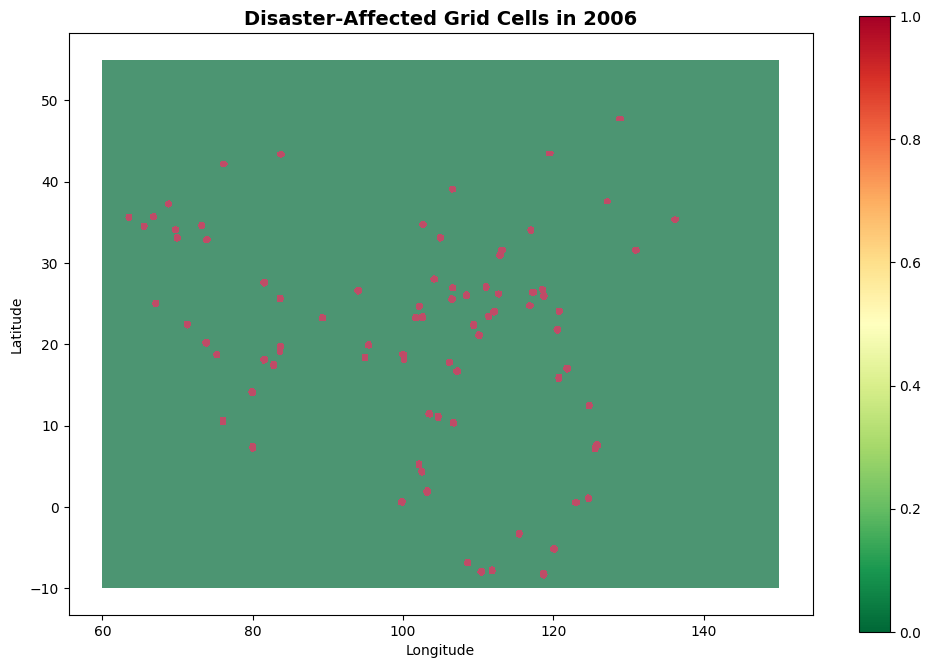

Treatment map saved to results\treatment_map_2006.png


In [45]:
# Step 8: Treatment Map Visualization
print("\n" + "="*80)
print("STEP 8: Spatial Visualization of Treatment")
print("="*80)

if 'grid_gdf' in locals() and 'treatment_df' in locals():
    # Pick a year with notable treatment
    treatment_by_year = treatment_df.groupby('year').size()
    peak_year = treatment_by_year.idxmax()
    
    print(f"Visualizing treatment for year {peak_year} (peak treatment year)")
    print(f"Number of treated cells in {peak_year}: {treatment_by_year[peak_year]}")
    
    plot_treatment_map(
        grid_gdf,
        treatment_df,
        year=peak_year,
        save_path=CONFIG['results_dir'] / f'treatment_map_{peak_year}.png'
    )
    print(f"Treatment map saved to {CONFIG['results_dir'] / f'treatment_map_{peak_year}.png'}")
else:
    print("ERROR: Grid or treatment data not found")

In [ ]:
# Step 9: Save Complete Results
print("\n" + "="*80)
print("STEP 9: Saving Complete Results")
print("="*80)

# Compile all results
results_dict = {}

if 'panel_df' in locals():
    results_dict['panel_data'] = panel_df
    
if 'did_results' in locals():
    results_dict['did_results'] = did_results
    results_dict['main_coef'] = did_results.params['treated']
    results_dict['main_se'] = did_results.std_errors['treated']
    
if 'event_study_coefs' in locals():
    results_dict['event_study_coefs'] = event_study_coefs
    
if 'species_results' in locals():
    results_dict['species_results'] = species_results
    
if 'grid_gdf' in locals():
    results_dict['grid'] = grid_gdf
    
if 'treatment_df' in locals():
    results_dict['n_treated'] = treatment_df['grid_id'].nunique()
    
if 'occurrence_panel' in locals():
    results_dict['n_species'] = occurrence_panel['species'].nunique()

# Save everything
save_analysis_results(results_dict, CONFIG['results_dir'])

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"\nResults saved to: {CONFIG['results_dir']}")
print("\nKey outputs:")
print(f"  - Analysis panel: {CONFIG['data_dir'] / 'processed' / 'analysis_panel.parquet'}")
print(f"  - Treatment panel: {CONFIG['data_dir'] / 'processed' / 'treatment_panel.csv'}")
print(f"  - Event study plot: {CONFIG['results_dir'] / 'event_study_plot.png'}")
print(f"  - Species effects: {CONFIG['results_dir'] / 'species_specific_results.csv'}")
print(f"  - Forest plot: {CONFIG['results_dir'] / 'species_effects_forest_plot.png'}")
print(f"  - Summary: {CONFIG['results_dir'] / 'summary.json'}")

## Results Summary

The analysis pipeline has completed. Review the outputs above for:

1. **Overall Treatment Effect**: DiD estimate of disaster impact on species occupancy
2. **Event Study**: Dynamic treatment effects over time (pre/post disaster)
3. **Species Heterogeneity**: Individual species responses to disasters
4. **Spatial Patterns**: Geographic distribution of treatment

### Next Steps:

- Review the event study plot for parallel trends assumption
- Examine species-specific results for heterogeneous effects
- Run robustness checks (cells in section 12-13)
- Consider alternative specifications or subgroup analyses

## Advanced Estimators

For more advanced causal inference methods, consider:

### Synthetic Control Method
For case studies with strong single treated unit (e.g., major disaster in specific region):

```python
# Placeholder for Synthetic Control
# Use synthdid or R's Synth package via rpy2
```

### Sun-Abraham (2021) Estimator
For heterogeneous treatment effects with staggered adoption:

```python
# Use pydid or R's did package
```

### Bayesian Hierarchical Model
For pooling across species with varying effects:

```python
import pymc as pm

# Model structure:
# outcome_{i,s,t} ~ Normal(mu_{i,s,t}, sigma)
# mu_{i,s,t} = alpha_s + beta_s * treatment_{i,t} + grid_effects + time_effects
# alpha_s ~ Normal(mu_alpha, sigma_alpha)  # species intercepts
# beta_s ~ Normal(mu_beta, sigma_beta)     # species treatment effects
```

## 15. Complete Analysis Workflow

### Step-by-step execution:

1. **Data acquisition:**
   - Download EM-DAT disasters → `data/raw/emdat_asia_2000_2024.csv`
   - Request GBIF download → wait for notification → download to `data/raw/gbif/occurrences.csv`
   - Download IUCN ranges → extract to `data/raw/iucn/`
   - (Optional) Download MODIS land cover → `data/raw/modis/`

2. **Preprocessing:**
   ```python
   # Load data
   emdat_df = load_emdat_data(...)
   gbif_df = load_and_process_gbif_occurrences(...)
   iucn_ranges = load_iucn_ranges(...)
   
   # Create spatial grid
   grid_gdf = create_analysis_grid(...)
   
   # Build panels
   treatment_df = build_treatment_panel(emdat_df, grid_gdf)
   occurrence_panel = build_occurrence_panel(gbif_df, grid_gdf)
   
   # Merge into analysis panel
   panel_df = prepare_panel_data(occurrence_panel, treatment_df, grid_gdf)
   ```

3. **Main estimation:**
   ```python
   # DiD
   did_res = estimate_twfe_did(panel_df, outcome_var='occupancy')
   
   # Event study
   es_res, es_coefs = estimate_event_study(panel_df, outcome_var='occupancy')
   
   # Plot
   plot_event_study(es_coefs, save_path=CONFIG['results_dir'] / 'event_study.png')
   ```

4. **Species-specific analysis:**
   ```python
   species_results = {}
   for species in panel_df['species'].unique():
       panel_sp = panel_df[panel_df['species'] == species]
       res = estimate_twfe_did(panel_sp, outcome_var='occupancy')
       species_results[species] = {
           'coef': res.params['treated'],
           'se': res.std_errors['treated'],
           'ci_lower': res.conf_int().loc['treated', 'lower'],
           'ci_upper': res.conf_int().loc['treated', 'upper']
       }
   
   plot_species_effects(species_results)
   ```

5. **Robustness:**
   ```python
   # Pre-trends
   f_stat = pretrend_test(es_coefs)
   
   # Placebo
   placebo_coefs = placebo_test(panel_df, 'occupancy', n_iterations=500)
   
   # Sensitivity
   sensitivity_results = sensitivity_alternative_resolution(occurrence_panel, treatment_df)
   ```

6. **Save outputs:**
   ```python
   results = {
       'panel_data': panel_df,
       'did_results': did_res,
       'event_study_coefs': es_coefs,
       'species_results': species_results,
       'grid': grid_gdf,
       'n_treated': treatment_df['grid_id'].nunique(),
       'n_species': panel_df['species'].nunique(),
       'main_coef': did_res.params['treated'],
       'main_se': did_res.std_errors['treated']
   }
   
   save_analysis_results(results, CONFIG['results_dir'])
   ```

### Next Steps:
- Fill in API credentials in Cell 3
- Download required datasets (see Data Sources in Cell 4)
- Execute cells sequentially
- Adjust parameters based on data characteristics
- Iterate with robustness checks

## 16. References & Resources

**Key Papers:**
- Callaway & Sant'Anna (2021): Difference-in-Differences with multiple time periods. *Journal of Econometrics*.
- Sun & Abraham (2021): Estimating dynamic treatment effects. *Journal of Econometrics*.
- Abadie et al. (2010): Synthetic control methods. *JASA*.

**Data Sources:**
- **EM-DAT:** https://www.emdat.be/
- **GBIF:** https://www.gbif.org/ (API: https://www.gbif.org/developer/occurrence)
- **IUCN Red List:** https://www.iucnredlist.org/resources/spatial-data-download
- **MODIS:** https://modis.gsfc.nasa.gov/
- **Copernicus:** https://emergency.copernicus.eu/

**Software:**
- `linearmodels` (Python): Panel data models - https://bashtage.github.io/linearmodels/
- `pydid` (Python): DiD estimators - https://github.com/py-econometrics/pydid
- `fixest` (R): Fast fixed effects - https://lrberge.github.io/fixest/
- `did` (R): Callaway-Sant'Anna - https://bcallaway11.github.io/did/

**Analysis Guidelines:**
- Roth et al. (2023): What's Trending in Difference-in-Differences? *JBES*.
- Cunningham (2021): Causal Inference: The Mixtape. Yale Press.

---

**Contact & Issues:**
For questions about this pipeline, open an issue or contact the maintainer.

**Citation:**
If you use this pipeline, please cite relevant data sources and methods papers.